As a summary of time-series models we've seen, it is possible to assert many traits and whims for series behavior, such as homoscedasticity, heteroscedasticity, covariance stationarity, non-stationary, and multivariate. Those methods, adequately implemented on `statsmodels` Python library, are wired on the `maximum likelihood estimator`. Furthermore, the fundamental inferential statistical theory lays the foundation for a Bayesian formulation of classical models. In this classical, we try to formulate the classical AR model/process by Bayesian means, with the aid of the Python library `pymc`. 

------------
Refs:
https://nathanielf.github.io/post/bayesian_structural_timeseries/       
https://docs.pymc.io/en/v3/api/distributions/timeseries.html     
https://juanitorduz.github.io/short_time_series_pymc/    

#### The Bayes estimator. 

Many ML practitioners may find convoluted to unwind bayesian proposal, in distinguish to classical estimators. For enlightment, we stuck to (Casella, Berger - Statistical Inference, Chapter 7).  


Let $\theta$ a parameter group of estimates. In the `classical approach`, those parameter are considered unknown yet fixed, and CI regards for the confidence of estimator about it; whereas in the `bayesian approach`, the variability of $\theta$ can be described by a probability distribution - named as prior distribution. 

Harbouring the Bayesian model, a sample comes from a population index by $\theta$, and the `priori` distribution is reshaped, renamed as `posterior`. To establish a mathematical notation, let $\pi(\theta)$ the prior of $\theta$, and $f(x|\theta)$ the sample data; the conditional of $\theta$ is given by the sample $x$ is.

$$ \pi(\theta|x) = f(x|\theta) \pi(\theta)/m(x), \quad (f(x|\theta)\pi(\theta) = f(x,\theta)) $$

where $m(x)$ is the marginal distribution of $X$

$$m(x) = \int f(x|\theta)\pi(\theta)d\theta.$$


For deeper details, please check out https://arxiv.org/abs/2011.01808

---------------
#### AR model

Let's replicate a basic Bayesian AR(1) Model. https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html 

In [15]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pymc3 as pm
import pandas as pd

Now, we simulate a simple AR(1) process of sample size 500.

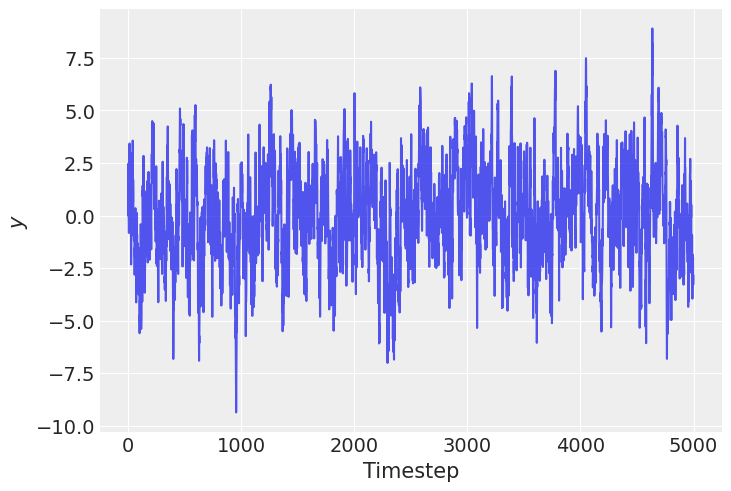

In [16]:
SAMPLE_SIZE = 5000
RANDOM_SEED = 42
y = np.zeros((SAMPLE_SIZE,))

# true stationarity
true_theta = 0.9
# true standard deviation of the innovation:
true_sigma = 1.0
# true process mean:
true_center = 0.0

for t in range(1, SAMPLE_SIZE):
    y[t] = true_theta * y[t - 1] + np.random.normal(loc=true_center, scale=true_sigma)

plt.plot(y, alpha=0.8)
plt.xlabel("Timestep")
plt.ylabel("$y$");

In [17]:
with pm.Model() as ar1:

    theta = pm.Normal("theta", 0.0, 1.0)
    tau = pm.Exponential("tau", 0.5)
    # process mean
    #center = pm.Normal("center", mu=0.0, sigma=1.0)
    
    likelihood = pm.AR1("y", k=theta, tau_e=tau, observed=y)

    trace = pm.sample(1000, random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/tmp/ipykernel_517860/2502154158.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


/home/jean/dev/Github/Longitudinal_Data/venv/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:214: UserWarning: A valid var_name should be provided, found {'center'} expected from {'tau', 'theta'}
  warnings.warn(


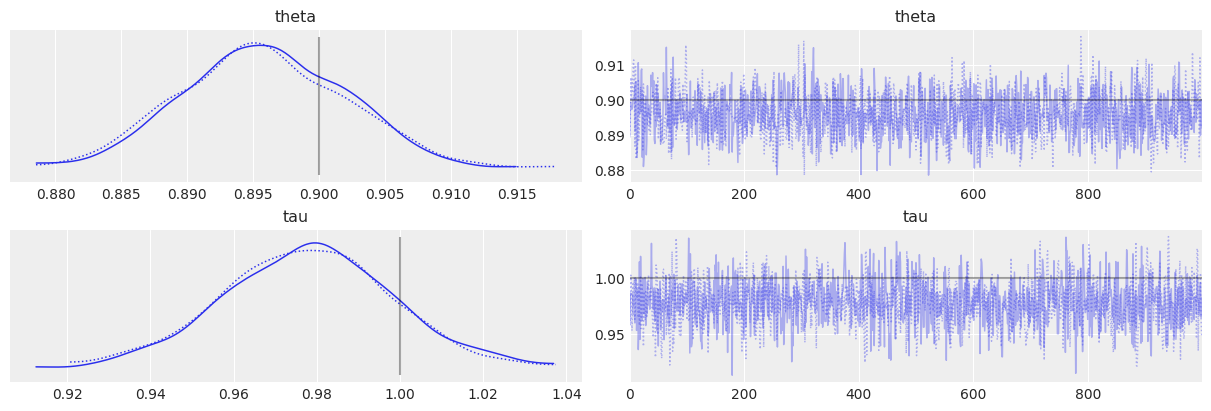

In [8]:
az.style.use("arviz-darkgrid")

az.plot_trace(
    idata,
    lines=[
        ("theta", {}, true_theta),
        ("tau", {}, true_sigma ** -2),
    ],
)

Fitting an AR(2) model.

In [9]:
with pm.Model() as ar2:
    theta = pm.Normal("theta", 0.0, 1.0, shape=2)
    sigma = pm.HalfNormal("sigma", 3)
    likelihood = pm.AR("y", theta, sigma=sigma, observed=y)

    trace = pm.sample(
        1000,
        random_seed=RANDOM_SEED,
    )
    idata = az.from_pymc3(trace)

/home/jean/dev/Github/Longitudinal_Data/venv/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


array([[<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

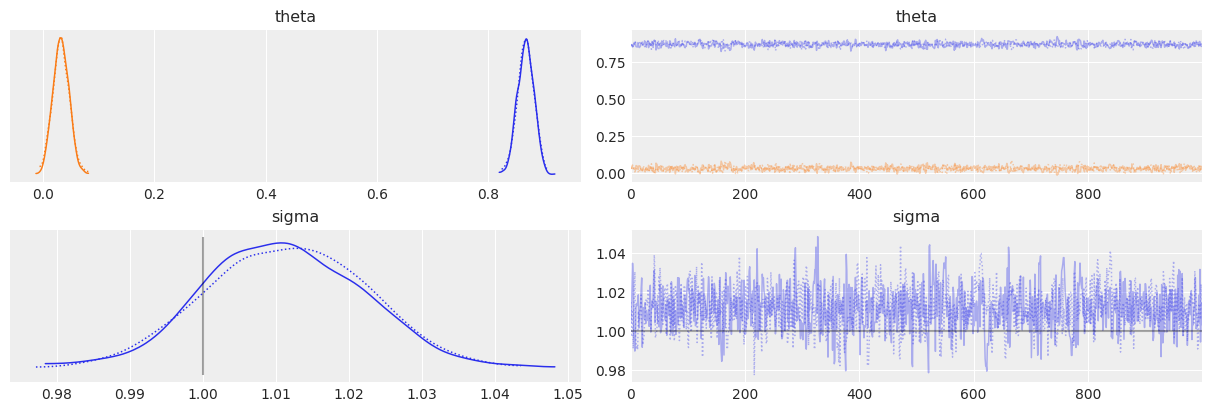

In [10]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {"theta_dim_0": 0}, true_theta),
        ("theta", {"theta_dim_0": 1}, 0.0),
        ("sigma", {}, true_sigma),
    ],
)

---------------------------
#### GARCH Model

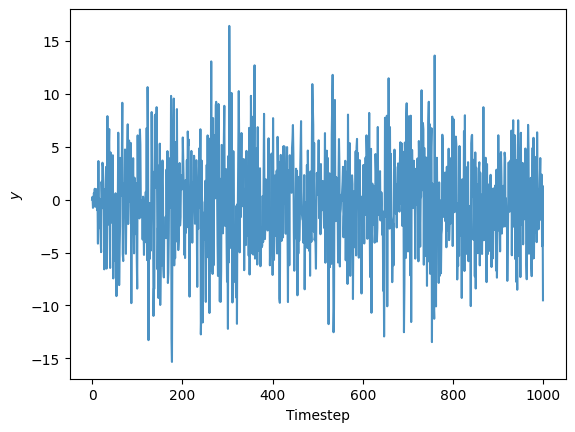

In [101]:
SAMPLE_SIZE = 1000
y_garch = np.zeros((SAMPLE_SIZE,))

sigma_garch = np.zeros((SAMPLE_SIZE,))

sigma_initial = 0.01
sigma_garch[0] = sigma_initial

omega = 0.5

true_alpha = 0.01

true_beta = 0.85


for t in range(1, SAMPLE_SIZE):
    
    sigma_garch[t] = np.sqrt(omega + true_alpha*y_garch[t - 1]**2 + true_beta*sigma_garch[t - 1]**2)
    
    
    y_garch[t] = np.random.normal(loc=0, scale=sigma_garch[t]**2)

plt.plot(y_garch, alpha=0.8)
plt.xlabel("Timestep")
plt.ylabel("$y$");

### The following code doesnt work.

In [104]:
with pm.Model() as garch:
    omega = pm.Normal("omega", 0.0, 1.0)
    alpha_1 = pm.Normal("alpha_1", 0.0, 1.0)
    beta_1 = pm.Normal("beta_1", 0.0, 1.0)
    initial_vol = pm.Normal("initial_vol", 0.0, 1.0)
    

    likelihood = pm.GARCH11("y", omega=omega, alpha_1=alpha_1, beta_1=beta_1, initial_vol=initial_vol, observed=y_garch)

    trace = pm.sample(
        1000,
        random_seed=RANDOM_SEED,
    )
    idata = az.from_pymc3(trace)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'omega': array(0.), 'alpha_1': array(0.), 'beta_1': array(0.), 'initial_vol': array(0.)}

Initial evaluation results:
omega         -0.92
alpha_1       -0.92
beta_1        -0.92
initial_vol   -0.92
y              -inf
Name: Log-probability of test_point, dtype: float64

####  A complete specification of air passenger data.
https://www.pymc.io/projects/examples/en/latest/time_series/Air_passengers-Prophet_with_Bayesian_workflow.html 




In [2]:
df = pd.read_csv('airpassenger/AirPassengers.csv')
df["Month"] = pd.to_datetime(df["Month"])

<AxesSubplot: xlabel='Month', ylabel='#Passengers'>

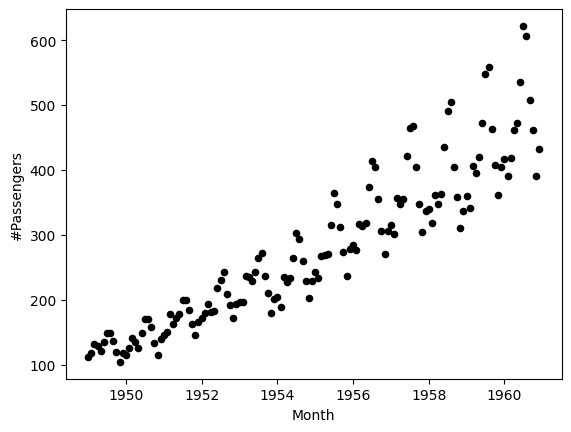

In [3]:
df.plot.scatter(x="Month", y="#Passengers", color="k")

Scaling the Passengers and time. 

In [4]:
t = (df["Month"] - pd.Timestamp("1900-01-01")).dt.days.to_numpy()
t_min = np.min(t)
t_max = np.max(t)
t = (t - t_min) / (t_max - t_min)

y = df["#Passengers"].to_numpy()
y_max = np.max(y)
y = y / y_max

As the documentation enlighten, this is a Prophet-like adjustment made on PyMC3. Therefore, we shall specify the complete model as prior to posteriorize.

1 - A linear trend

$$ Passengers \sim \alpha + \beta time $$


Setting up the priors.

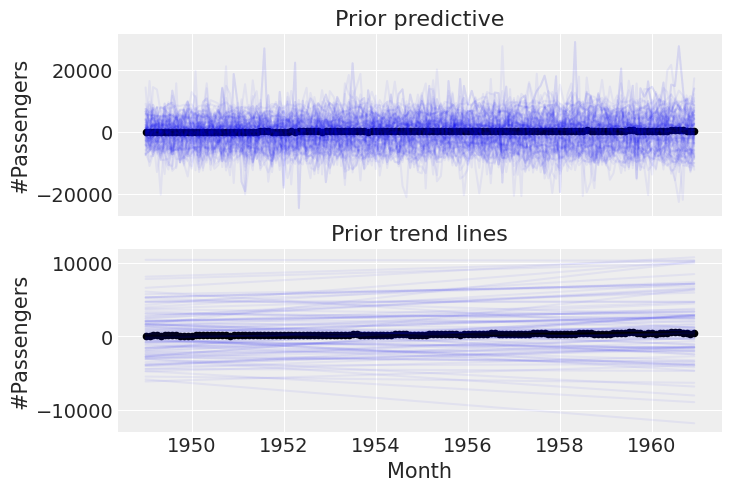

In [5]:
az.style.use("arviz-darkgrid")

def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement"""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]


with pm.Model(check_bounds=False) as linear:
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=5)
    trend = pm.Deterministic("trend", alpha + beta * t)
    pm.Normal("likelihood", mu=trend, sigma=sigma, observed=y)

    linear_prior_predictive = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["Month"],
    _sample(linear_prior_predictive["likelihood"], 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"], _sample(linear_prior_predictive["trend"], 100).T * y_max, color="blue", alpha=0.05
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines");

Posterior predictive

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


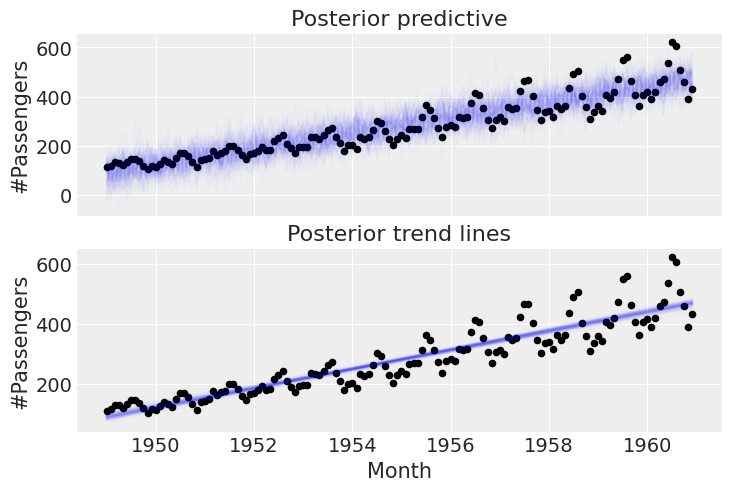

In [7]:
with linear:
    linear_trace = pm.sample(return_inferencedata=True)
    linear_posterior_predictive = pm.sample_posterior_predictive(trace=linear_trace)

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(
    df["Month"],
    _sample(linear_posterior_predictive["likelihood"], 100).T * y_max,
    color="blue",
    alpha=0.01,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
posterior_trend = linear_trace.posterior["trend"].stack(sample=("draw", "chain")).T
ax[1].plot(df["Month"], _sample(posterior_trend, 100).T * y_max, color="blue", alpha=0.01)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines");




2 - Seasonality

$$ Passengers \sim (\alpha + \beta time)(1 + seasonality) $$


Prophet paper (https://peerj.com/preprints/3190/) proposes Fourier features for modeling the seasonality.

In [9]:
n_order = 10
periods = (df["Month"] - pd.Timestamp("1900-01-01")).dt.days / 365.25

fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)
fourier_features

,sin_order_1,cos_order_1,sin_order_2,cos_order_2,sin_order_3,cos_order_3,sin_order_4,cos_order_4,sin_order_5,cos_order_5,sin_order_6,cos_order_6,sin_order_7,cos_order_7,sin_order_8,cos_order_8,sin_order_9,cos_order_9,sin_order_10,cos_order_10
0,-0.004301,0.999991,-0.008601,0.999963,-0.012901,0.999917,-0.017202,0.999852,-0.021501,0.999769,-0.025801,0.999667,-0.030100,0.999547,-0.034398,0.999408,-0.038696,0.999251,-0.042993,0.999075
1,0.504648,0.863325,0.871351,0.490660,0.999870,-0.016127,0.855075,-0.518505,0.476544,-0.879150,-0.032249,-0.999480,-0.532227,-0.846602,-0.886721,-0.462305,-0.998830,0.048363,-0.837909,0.545811
2,0.847173,0.531317,0.900235,-0.435405,0.109446,-0.993993,-0.783934,-0.620844,-0.942480,0.334263,-0.217577,0.976043,0.711276,0.702913,0.973402,-0.229104,0.323093,-0.946367,-0.630072,-0.776537
3,0.999639,0.026876,0.053732,-0.998555,-0.996751,-0.080549,-0.107308,0.994226,0.990983,0.133990,0.160575,-0.987024,-0.982352,-0.187043,-0.213377,0.976970,0.970882,0.239557,0.265563,-0.964094
4,0.882712,-0.469915,-0.829598,-0.558361,-0.103031,0.994678,0.926430,-0.376467,-0.767655,-0.640864,-0.204966,0.978769,0.960288,-0.279012,-0.697540,-0.716546,-0.304719,0.952442,0.983924,-0.178587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,-0.484089,-0.875019,0.847173,0.531317,-0.998497,-0.054805,0.900235,-0.435405,-0.576948,0.816781,0.109446,-0.993993,0.385413,0.922744,-0.783934,-0.620844,0.986501,0.163757,-0.942480,0.334263
140,-0.861693,-0.507430,0.874498,-0.485029,-0.025801,0.999667,-0.848314,-0.529494,0.886721,-0.462305,-0.051584,0.998669,-0.834370,-0.551205,0.898354,-0.439273,-0.077334,0.997005,-0.819871,-0.572548
141,-0.999870,-0.016127,0.032249,-0.999480,0.998830,0.048363,-0.064464,0.997920,-0.996751,-0.080549,0.096613,-0.995322,0.993635,0.112651,-0.128661,0.991689,-0.989485,-0.144636,0.160575,-0.987024
142,-0.869233,0.494403,-0.859503,-0.511131,0.019352,-0.999813,0.878637,-0.477489,0.849450,0.527668,-0.038696,0.999251,-0.887713,0.460397,-0.839080,-0.544008,0.058026,-0.998315,0.896456,-0.443132


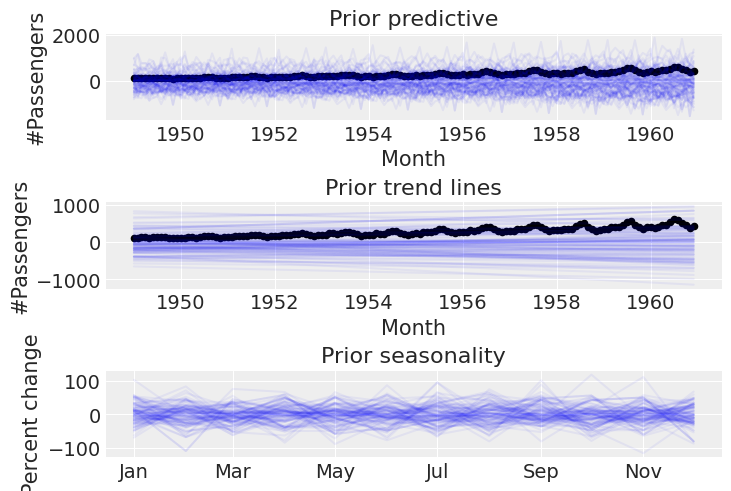

In [13]:
coords = {"fourier_features": np.arange(2 * n_order)}
with pm.Model(check_bounds=False, coords=coords) as linear_with_seasonality:
    alpha = pm.Normal("alpha", mu=0, sigma=0.5)
    beta = pm.Normal("beta", mu=0, sigma=0.5)
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    beta_fourier = pm.Normal("beta_fourier", mu=0, sigma=.1, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(beta_fourier, fourier_features.to_numpy().T)
    )
    trend = pm.Deterministic("trend", alpha + beta * t)
    mu = trend * (1 + seasonality)
    pm.Normal("likelihood", mu=mu, sigma=sigma, observed=y)

    linear_with_seasonality_prior_predictive = pm.sample_prior_predictive()

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False)
ax[0].plot(
    df["Month"],
    _sample(linear_with_seasonality_prior_predictive["likelihood"], 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    df["Month"],
    _sample(linear_with_seasonality_prior_predictive["trend"], 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    df["Month"].iloc[:12],
    _sample(linear_with_seasonality_prior_predictive["seasonality"][:, :12], 100).T * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_fourier, sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.


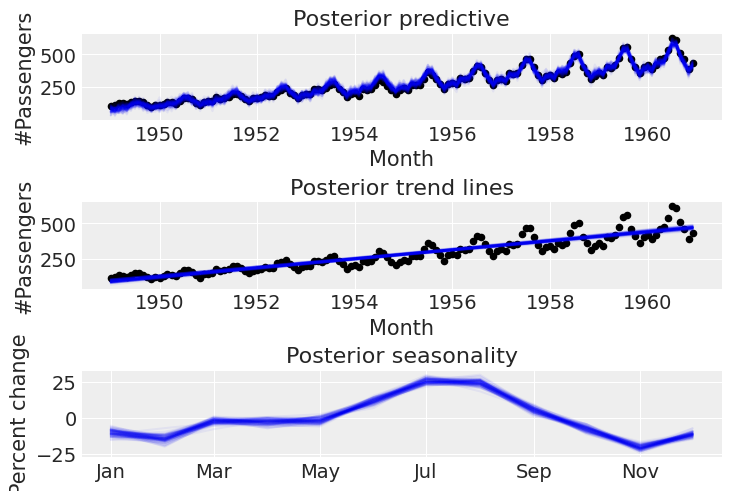

In [14]:
with linear_with_seasonality:
    linear_with_seasonality_trace = pm.sample(return_inferencedata=True)
    linear_with_seasonality_posterior_predictive = pm.sample_posterior_predictive(
        trace=linear_with_seasonality_trace
    )

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False)
ax[0].plot(
    df["Month"],
    _sample(linear_with_seasonality_posterior_predictive["likelihood"], 100).T * y_max,
    color="blue",
    alpha=0.05,
)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[0])
ax[0].set_title("Posterior predictive")
posterior_trend = linear_trace.posterior["trend"].stack(sample=("draw", "chain")).T
ax[1].plot(df["Month"], _sample(posterior_trend, 100).T * y_max, color="blue", alpha=0.05)
df.plot.scatter(x="Month", y="#Passengers", color="k", ax=ax[1])
ax[1].set_title("Posterior trend lines")
posterior_seasonality = (
    linear_with_seasonality_trace.posterior["seasonality"].stack(sample=("draw", "chain")).T
)
ax[2].plot(
    df["Month"].iloc[:12],
    _sample(posterior_seasonality[:, :12], 100).T * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Posterior seasonality")
ax[2].set_ylabel("Percent change")
formatter = mdates.DateFormatter("%b")
ax[2].xaxis.set_major_formatter(formatter)

@incollection{citekey,
  author    = "<notebook authors, see above>"
  title     = "<notebook title>",
  editor    = "PyMC Team",
  booktitle = "PyMC examples",
  doi       = "10.5281/zenodo.5654871"
}